Importing required libraries

In [1]:
from Tumor_Classifier_Utils import *

Loading in the data

In [2]:
data_train = scio.loadmat('Data/tumor_train_data_64.mat')
data_val = scio.loadmat('Data/tumor_val_data_64.mat')
data_test = scio.loadmat('Data/tumor_test_data_64.mat')

N = 64 # image dimensions (N x N after preprocessing)
num_classes = 4; # how many different types of classifications we have 

x_train = np.transpose(data_train['img_train'], (2, 0, 1)).reshape(-1, N, N, 1)
y_train = data_train['labels_train']
x_val = np.transpose(data_val['img_val'], (2, 0, 1)).reshape(-1, N, N, 1)
y_val = data_val['labels_val']
x_test = np.transpose(data_test['img_test'], (2, 0, 1)).reshape(-1, N, N, 1)
y_test = data_test['labels_test']


print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(2450, 64, 64, 1)
(283, 64, 64, 1)
(350, 64, 64, 1)
(2450, 1)
(283, 1)
(350, 1)


Checking Data

In [3]:
print(data_train['img_train'].shape)
print(data_train['labels_train'].shape)
print(data_val['img_val'].shape)
print(data_val['labels_val'].shape)
print(data_test['img_test'].shape)
print(data_test['labels_test'].shape)


(64, 64, 2450)
(2450, 1)
(64, 64, 350)
(350, 1)
(64, 64, 283)
(283, 1)


Visualisartion of data

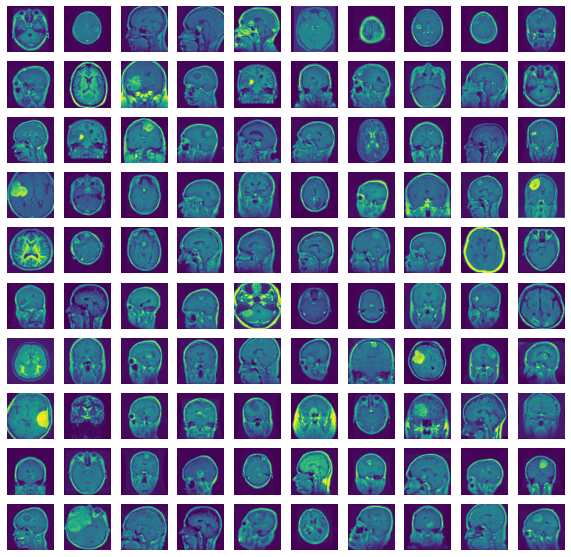

In [4]:
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(data_train['img_train'][:,:,i])
    ax.axis('off')

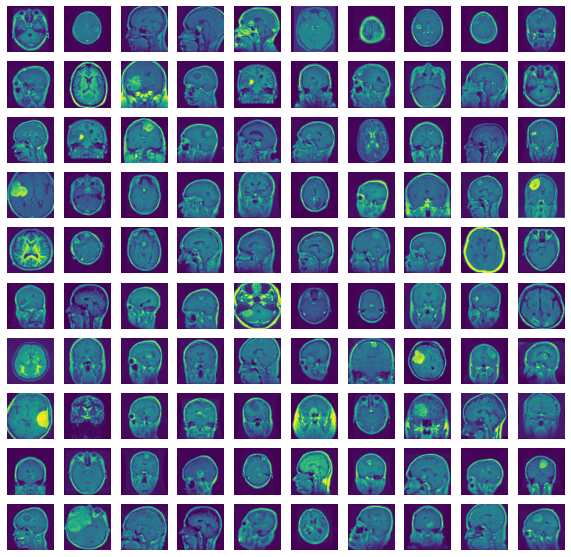

In [5]:
train = np.transpose(data_train['img_train'], (2, 0, 1)).reshape(-1, N, N, 1)
train_y = data_train['labels_train']
val = np.transpose(data_val['img_val'], (2, 0, 1)).reshape(-1, N, N, 1)
val_y = data_val['labels_val']
test = np.transpose(data_test['img_test'], (2, 0, 1)).reshape(-1, N, N, 1)
test_y = data_test['labels_test']

fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(train[i,:,:,0])
    ax.axis('off')    

### Network Architecture

In [6]:
num_epochs = 30 # how many training epochs we are doing

# build model function
def build_model(num_classes, output_activation=None):
    # Input in an image shape
    inputs = keras.Input(shape=(N, N, 1, ), name='img')
    
    # run pairs of conv layers, all 3s3 kernels
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(inputs) # consider using alternate activation
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation=None)(x)
    # batch normalisation, before the non-linearity
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # spatial dropout, this will drop whole kernels, i.e. 20% of our 3x3 filters will be dropped out rather
    # than dropping out 20% of the invidual pixels
    x = layers.SpatialDropout2D(0.2)(x)
    # max pooling, 2x2, which will downsample the image
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    # rinse and repeat with 2D convs, batch norm, dropout and max pool
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x) # consider using alternate activation
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.2)(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    # final conv2d, batch norm and spatial dropout
    x = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(x) # consider using alternate activation
    x = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.2)(x)

    # flatten layer
    x = layers.Flatten()(x)
    
    # Neuron setup
    x = layers.Dense(256, activation='relu')(x) # consider using alternate activation
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x) # consider using alternate activation
    #x = layers.Dense(4, activation='softmax')(x)
    
    # the output
    outputs = layers.Dense(num_classes, activation=output_activation)(x)

    # build the model, and print a summary
    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='tumor_classifier_cnn_model')
    
    return model_cnn

In [7]:
model_cnn = build_model(4)
model_cnn.summary()

Model: "tumor_classifier_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 16)       64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 16)        0         
                                                                 
 spatial_dropout2d (SpatialD  (None, 64, 64, 16)       0         
 ropout2D)                              

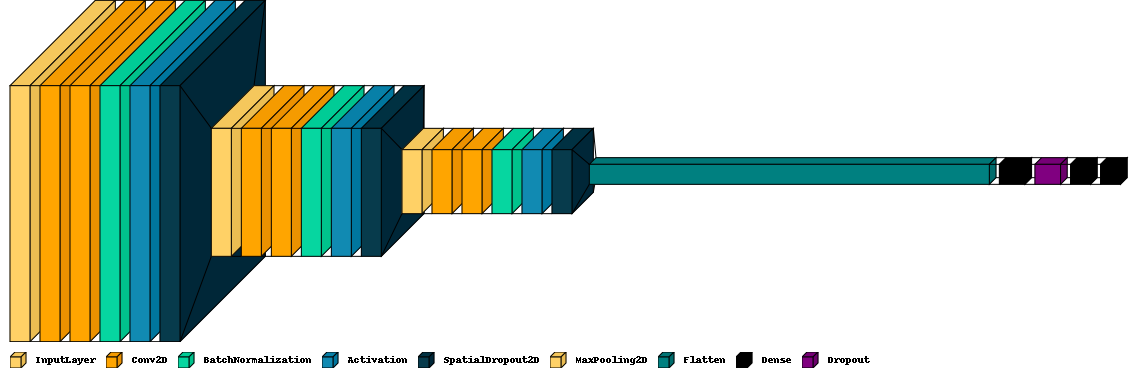

In [8]:
cmp = defaultdict(dict)
cmp[layers.Conv2D]['fill'] = 'orange'
cmp[layers.MaxPooling2D]['filal'] = 'red'
cmp[layers.Dense]['fill'] = 'black'
cmp[layers.Flatten]['fill'] = 'teal'
cmp[layers.Dropout]['fill'] = 'purple'
vk.layered_view(model_cnn, legend=True, color_map=cmp)

Training the model

In [9]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Nadam(),
              metrics=['accuracy'])
classWeights = class_weights()
history = model_cnn.fit(train, train_y,
                        batch_size=128,
                        epochs=100,
                        class_weight=classWeights,
                        validation_data=(val, val_y))

Epoch 1/100
20/20 [==============================] - 7s 48ms/step - loss: 2.6921 - accuracy: 0.3669 - val_loss: 1.3860 - val_accuracy: 0.1286
Epoch 2/100
20/20 [==============================] - 0s 21ms/step - loss: 1.2691 - accuracy: 0.5159 - val_loss: 1.3929 - val_accuracy: 0.1429
Epoch 3/100
20/20 [==============================] - 0s 21ms/step - loss: 1.1461 - accuracy: 0.5588 - val_loss: 1.4183 - val_accuracy: 0.2857
Epoch 4/100
20/20 [==============================] - 0s 21ms/step - loss: 1.0666 - accuracy: 0.5853 - val_loss: 1.5426 - val_accuracy: 0.1429
Epoch 5/100
20/20 [==============================] - 0s 21ms/step - loss: 1.0225 - accuracy: 0.6020 - val_loss: 1.6053 - val_accuracy: 0.1429
Epoch 6/100
20/20 [==============================] - 0s 21ms/step - loss: 0.9611 - accuracy: 0.6082 - val_loss: 1.7140 - val_accuracy: 0.1429
Epoch 7/100
20/20 [==============================] - 0s 21ms/step - loss: 0.8776 - accuracy: 0.6290 - val_loss: 1.6337 - val_accuracy: 0.1429
Epoch 

['loss', 'accuracy', 'val_loss', 'val_accuracy']
['loss', 'val_loss']
['accuracy', 'val_accuracy']


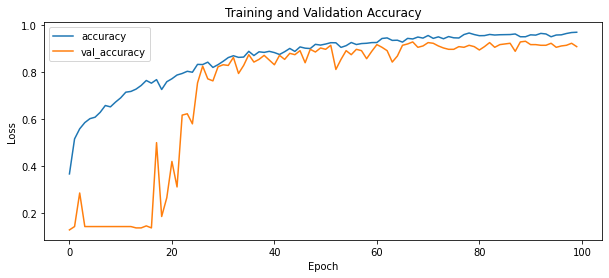

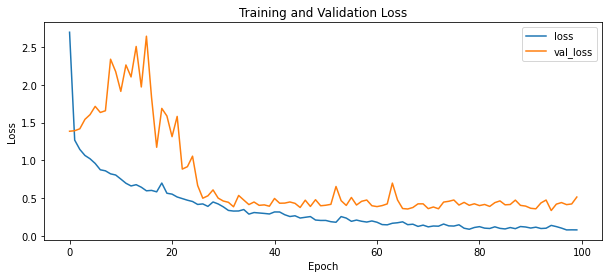

In [10]:
plot_loss(history)

### Model Evaluation

              precision    recall  f1-score   support

           0       0.46      0.75      0.57         8
           1       0.80      0.83      0.82       102
           2       0.88      0.83      0.85       127
           3       0.98      0.96      0.97        46

    accuracy                           0.85       283
   macro avg       0.78      0.84      0.80       283
weighted avg       0.86      0.85      0.85       283



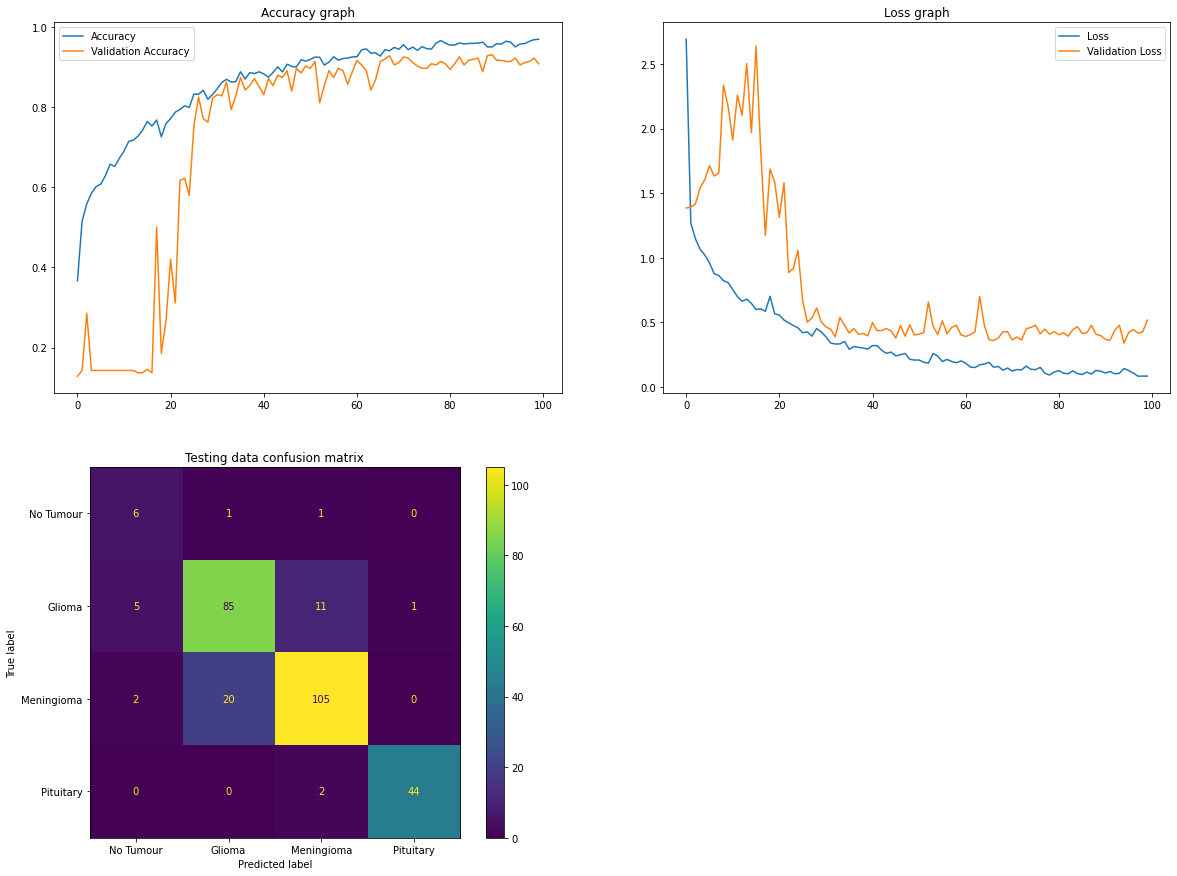

In [11]:
def eval_model(model, history, x_train, y_train, x_test, y_test):

    fig = plt.figure(figsize=[20, 15])    

    ax = fig.add_subplot(2, 2, 1)
    ax.plot(history['accuracy'], label='Accuracy')
    ax.plot(history['val_accuracy'], label='Validation Accuracy')
    ax.legend()
    ax.set_title('Accuracy graph')

    ax = fig.add_subplot(2, 2, 2)
    ax.plot(history['loss'], label='Loss')
    ax.plot(history['val_loss'], label='Validation Loss')
    ax.legend()
    ax.set_title('Loss graph')
    
    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    cm = confusion_matrix(y_test, indexes)

    ax = fig.add_subplot(2, 2, 3)
    labels = ['No Tumour', 'Glioma', 'Meningioma', 'Pituitary']
    c = ConfusionMatrixDisplay(cm, display_labels=labels)
    c.plot(ax = ax)
    ax.set_title('Testing data confusion matrix')
    
    print(classification_report(y_test, indexes))

eval_model(model_cnn, history.history, train, train_y, test, test_y)

c:\Users\61424\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\61424\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


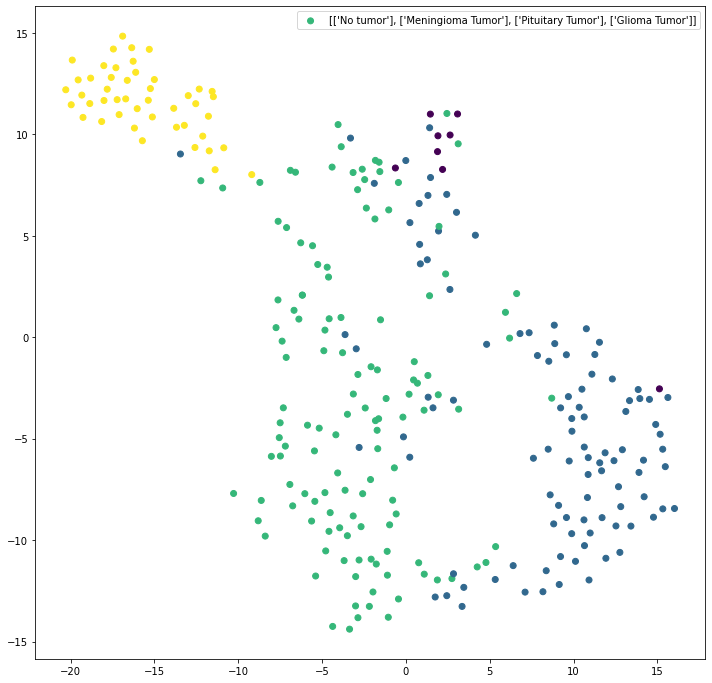

In [12]:
pred = model_cnn.predict(test);
tsne_embeddings = TSNE(random_state=4).fit_transform(pred)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
labels = [['No tumor'], ['Meningioma Tumor'], ['Pituitary Tumor'], ['Glioma Tumor']]
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = test_y.flatten(), label=labels);
plt.legend()
plt.show()